In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms

from PIL import Image
from tempfile import TemporaryDirectory
import numpy as np
import matplotlib.pyplot as plt
import shutil as sh
import time
import os


cudnn.benchmark = True
plt.ion()   # interactive mode

img_size = 224 # ResNet needs this image size

This is for fixing the Food-101 structure

In [12]:
def fixFood101(path: str):
    if os.path.exists(path):
        if os.path.exists(path + "/images/test/"):
            print("The structure is already fixed!")
            return
        
        file = open(path + "/meta/train.txt")
        list = file.readlines()
        file.close()

        for item in list:
            os.makedirs(path + "/images/train/"+item.split("/")[0], exist_ok=True)
            sh.move(path + "/images/"+item[:-1]+".jpg", path + "/images/train/"+item[:-1]+".jpg")

        file = open(path + "/meta/test.txt")
        list = file.readlines()
        file.close()

        for item in list:
            os.makedirs(path + "/images/test/"+item.split("/")[0], exist_ok=True)
            sh.move(path + "/images/"+item[:-1]+".jpg", path + "/images/test/"+item[:-1]+".jpg")

        for dirPath, _, _ in os.walk(path + "/images/"):
            try:
                os.rmdir(dirPath)
            except:
                pass
    else:
        print("Couldn't find food-101")
fixFood101("../Image Recognition/Datasets/food-101")

The structure is already fixed!


Function for preprocessing

In [ ]:
def preprocess(org_path: str, train: bool):
    image = Image.open(org_path)
    image = image.resize((img_size, img_size), Image.Resampling.HAMMING)

    if image.mode in ("RGBA", "LA"): #If the image has transparency, get rid of it
        background = Image.new("RGB", image.size, (255, 255, 255)) #Create a white image to act as the background
        background.paste(image, mask=image.split()[3]) #Apply this background where there is transparency on the image
        image = background

    dst = ""

    arr = org_path.split("/")
    dst_start = "/".join(arr[:arr.index("Datasets") + 1])

    if train:
        dst = dst_start + "/Cleaned/train/" + "/".join(org_path.split("/")[-2:])
    else:
        dst = dst_start + "/Cleaned/test/" + "/".join(org_path.split("/")[-2:])

    if not (dst.endswith(".jpg") or dst.endswith(".jpeg")):
        dst = ".".join(dst.split(".")[:-1]) + ".jpg"

    os.makedirs("/".join(dst.split("/")[:-1]), exist_ok=True)
    image.save(dst, "JPEG")     

In [43]:
for dirPath, _, files in os.walk("../Image Recognition/Datasets/food-101/images/train/"):
    if files:
        for file in files:
            preprocess(dirPath+"/"+file, True)

for dirPath, _, files in os.walk("../Image Recognition/Datasets/food-101/images/test/"):
    if files:
        for file in files:
            preprocess(dirPath+"/"+file, False)

In [ ]:
data_dir = '../Image Recognition/Datasets/Cleaned'

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("cuda:0" if torch.cuda.is_available() else "cpu")
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=14)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes


cpu


/home/pilar/miniconda3/envs/pt/lib/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


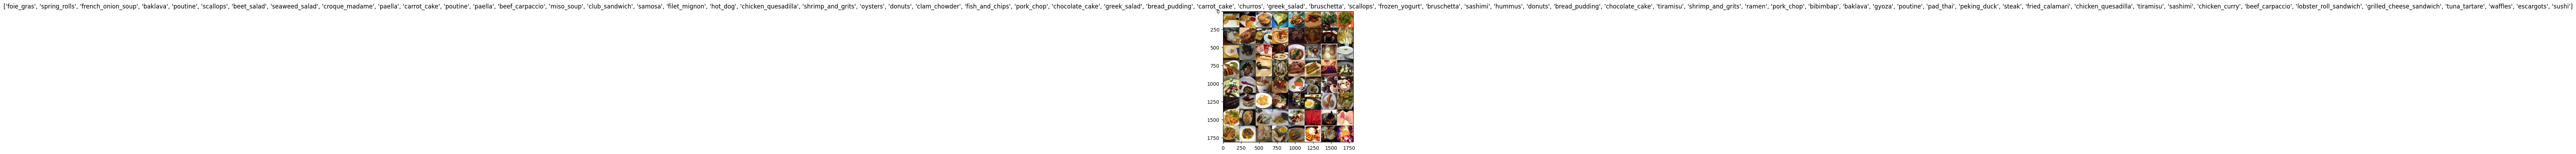

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [5]:
model_ft = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.

for name, param in model_ft.named_parameters():
    print(f"{name}: {param.retains_grad}")

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

#model_ft = model_ft.to(device)

#criterion = nn.CrossEntropyLoss()

## Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

## Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/pilar/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100.0%


conv1.weight: False
bn1.weight: False
bn1.bias: False
layer1.0.conv1.weight: False
layer1.0.bn1.weight: False
layer1.0.bn1.bias: False
layer1.0.conv2.weight: False
layer1.0.bn2.weight: False
layer1.0.bn2.bias: False
layer1.0.conv3.weight: False
layer1.0.bn3.weight: False
layer1.0.bn3.bias: False
layer1.0.downsample.0.weight: False
layer1.0.downsample.1.weight: False
layer1.0.downsample.1.bias: False
layer1.1.conv1.weight: False
layer1.1.bn1.weight: False
layer1.1.bn1.bias: False
layer1.1.conv2.weight: False
layer1.1.bn2.weight: False
layer1.1.bn2.bias: False
layer1.1.conv3.weight: False
layer1.1.bn3.weight: False
layer1.1.bn3.bias: False
layer1.2.conv1.weight: False
layer1.2.bn1.weight: False
layer1.2.bn1.bias: False
layer1.2.conv2.weight: False
layer1.2.bn2.weight: False
layer1.2.bn2.bias: False
layer1.2.conv3.weight: False
layer1.2.bn3.weight: False
layer1.2.bn3.bias: False
layer2.0.conv1.weight: False
layer2.0.bn1.weight: False
layer2.0.bn1.bias: False
layer2.0.conv2.weight: False
l

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------


OutOfMemoryError: CUDA out of memory. Tried to allocate 196.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Including non-PyTorch memory, this process has 17179869184.00 GiB memory in use. Of the allocated memory 10.38 GiB is allocated by PyTorch, and 41.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)